<a href="https://colab.research.google.com/github/tuilasue/2022-Spending-Prediction/blob/main/2022_Spending_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spending Projection Project**

Date: December 2021 - January 2022

Author: Cat Luong (BS. Computer Science), Sue Huynh (BS. Business Analytics and Marketing)



# Introduction


**Problem Statement:** 

For international students, expenditures for daily life and tuition cost a fortune for their families back home. Hence, we want to take a closer look on how we spent for our needs and wants in U.S during our freshman and sophomore year to:



*   **Estimate** monthly and yearly spending of a U.S college student for their basic needs and wants (excluding tuition and fees)
*   **Forecast** future spending - in 2022 - to have more control over budgeting in the future.

**Description:**

Dataset: Bank statement for 2020 and 2021 from JPMorgan Chase in .csv format.

Programming language: 


*   Python: data exploration, model implementation and data forecast (machine learning)
*   SQL: data cleaning (create many dataframes following criterias for years, months, and spending amounts), data exploration
*   Excel VBA: date/time reformatting

Method:




# Execution

## 1 - Load data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from scipy import stats
from sklearn import linear_model
from mlxtend.preprocessing import minmax_scaling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
finance_file_path = '/content/drive/MyDrive/SpendingProject/Financial Project.CSV'
# read the data and store data in finance
finance_data = pd.read_csv(finance_file_path) 
#print a summary of the data in spending summary
new_data_path = '/content/drive/MyDrive/SpendingProject/Financial Project-adjusted.CSV'
new_finance_data = pd.read_csv(new_data_path)

## 2 - Data Exploratory

First, we look at the total spending each month in 2021 with the raw data

In [ ]:
new_finance_data.describe()

,Spending,Balance,Check or Slip #
count,292.000000,292.000000,1.0
mean,-38.194829,3301.146336,1.0
std,1356.262126,3075.981050,NaN
min,-13600.000000,43.510000,1.0
25%,0.037500,1705.020000,1.0
50%,10.000000,2694.290000,1.0
75%,30.175000,3644.432500,1.0
max,6612.200000,15954.000000,1.0


In [ ]:
finance_data

,Details,Posting Date,Description,Spending,Type,Balance,Check or Slip #
0,DEBIT,12/30/2021,POS DEBIT Bishops Cuts/Color ...,55.00,MISC_DEBIT,3554.46,NaN
1,DEBIT,12/30/2021,POS DEBIT kfteausa_177 ...,13.00,MISC_DEBIT,3609.46,NaN
2,DEBIT,12/29/2021,KROGER #929 1 WEST COR CINCINNATI OH 260162 1...,8.95,DEBIT_CARD,3622.46,NaN
3,DEBIT,12/28/2021,GOIN POSTAL - LIBERTY CINCINNATI OH 1...,7.55,DEBIT_CARD,3631.41,NaN
4,DEBIT,12/27/2021,Amazon Prime*162HK6S Amzn.com/bill WA 1...,7.10,DEBIT_CARD,3638.96,NaN
...,...,...,...,...,...,...,...
287,DEBIT,1/6/2020,DOMESTIC INCOMING WIRE FEE,15.00,FEE_TRANSACTION,15898.26,NaN
288,DEBIT,1/6/2020,MARSHALLS 14401 INGLEW NAWTHORNE CA 0...,40.74,DEBIT_CARD,15913.26,NaN
289,CREDIT,1/6/2020,CHIPS CREDIT VIA: THE BANK OF NEW YORK MELLON/...,-13600.00,WIRE_INCOMING,15954.00,NaN
290,DEBIT,1/3/2020,DOORDASH WWW.DOORDASH. CA 0...,19.08,DEBIT_CARD,2354.00,NaN


We saw that the dataset records all of the inflows and outflows instead of just the outflow of money.

Hence, we will filter out all of the transactions that are NOT inflows (which must be **POSITIVE**)

However, there are many money inflows in small amount that from friends paying back for the bills.

> Select only spending transactions that are larger than (-45). In other words, we set the lower bound to be (-45).



In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
PROJECT_ID = 'financial-data-2020-2021'

# Import the BQ API Client library
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location='US')

# Construct a reference to the Ames Housing dataset that is within the project
dataset_ref = client.dataset('spending', project=PROJECT_ID)

# Make an API request to fetch the dataset
dataset = client.get_dataset(dataset_ref)

Authenticated


In [ ]:
#filter data
spd_month_query = """
SELECT 
    EXTRACT(year from posting_date) as year,
    EXTRACT(month from posting_date) as month,
    ROUND(SUM(spending),2) AS mth_spd
FROM `financial-data-2020-2021.spending.new-fp`
WHERE spending >= -45
GROUP BY year, month 
ORDER BY year, month 
"""

# Set up the query
spd_month_query_job = client.query(spd_month_query)

# Make an API request  to run the query and return a pandas DataFrame
spd_month = spd_month_query_job.to_dataframe()

# See the resulting table made from the query
spd_month.head(21)

,year,month,mth_spd
0,2020,1,8349.20
1,2020,2,94.34
2,2020,3,780.27
3,2020,4,56.09
4,2020,5,7.09
5,2020,6,7.09
6,2020,7,7.09
7,2020,8,6668.45
8,2020,9,329.99
9,2020,10,1750.00


In [ ]:
spd_month.describe()

,year,month,mth_spd
count,22.000000,22.000000,22.000000
mean,2020.454545,6.545455,1748.710000
std,0.509647,3.673940,2836.593968
min,2020.000000,1.000000,7.090000
25%,2020.000000,3.250000,62.545000
50%,2020.000000,6.500000,352.035000
75%,2021.000000,9.750000,1542.802500
max,2021.000000,12.000000,8349.200000


## 3 - Model Implementation

Next, let's look closer to the spending in 2020

In [ ]:
df_2020 = spd_month[spd_month['year']==2020]
df_2020

,year,month,mth_spd
0,2020,1,8349.20
1,2020,2,94.34
2,2020,3,780.27
3,2020,4,56.09
4,2020,5,7.09
5,2020,6,7.09
6,2020,7,7.09
7,2020,8,6668.45
8,2020,9,329.99
9,2020,10,1750.00


In [ ]:
df_2020.describe()

,year,month,mth_spd
count,12.0,12.000000,12.000000
mean,2020.0,6.500000,1513.565833
std,0.0,3.605551,2868.171806
min,2020.0,1.000000,7.090000
25%,2020.0,3.750000,7.090000
50%,2020.0,6.500000,100.215000
75%,2020.0,9.250000,1022.702500
max,2020.0,12.000000,8349.200000


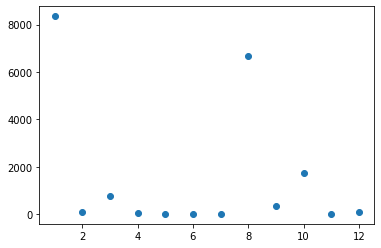

In [ ]:
plt.scatter(df_2020['month'], df_2020['mth_spd'])
plt.show()

The graph above shows there are 2 big increases in January (8349.20) and July (6668.45). Besides, the spending minimum (7.09) is significantly smaller than the average spending in 2021. 

To eliminate these possible outliers:

> Replace with the average spending per month in 2020

In [ ]:
mean_spd_2020 = df_2020['mth_spd'].mean()
mean_spd_2020 = round(mean_spd_2020, 2)

In [ ]:
df_2020['mth_spd'] = df_2020['mth_spd'].replace([8349.20],mean_spd_2020)
df_2020['mth_spd'] = df_2020['mth_spd'].replace([6668.45],mean_spd_2020)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_2020['mth_spd'] = df_2020['mth_spd'].replace([7.09], mean_spd_2020)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#new 2020 spending data
df_2020

,year,month,mth_spd
0,2020,1,1513.57
1,2020,2,94.34
2,2020,3,780.27
3,2020,4,56.09
4,2020,5,1513.57
5,2020,6,1513.57
6,2020,7,1513.57
7,2020,8,1513.57
8,2020,9,329.99
9,2020,10,1750.00


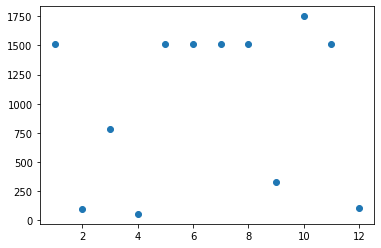

In [ ]:
plt.scatter(df_2020['month'], df_2020['mth_spd'])
plt.show()

Because there are still quite a large gap among the data points in 2020, we will use Support Vector Regression model for this data set to have more precise prediction for 2022. First we will try to use only the data in 2020 for prediction. 

First, we scale down data to (-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler 
X = df_2020['month'].values
y = df_2020['mth_spd'].values
sc_X = StandardScaler() 
sc_y = StandardScaler() 
X = sc_X.fit_transform(X.reshape(-1, 1)) 
y = sc_y.fit_transform(y.reshape(-1, 1))

In [ ]:
print(X.shape)
print(y.shape)

(12, 1)
(12, 1)


We will split the spending data in 2020 into test and train data. 

At this state, we are splitting dataset in 0.75 to train and 0.25 to test.

In [ ]:
from sklearn.model_selection import train_test_split 
 
# Splitting the dataset into 80% training data and 25% testing data.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.25, random_state=42)


In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9, 1), (3, 1), (9, 1), (3, 1))

Now we will implement the model. Here we use the Support Vector Regression model for this problem. 

The reason why we are using Support Vector Regression is because according to the data exploratory analysis, our data is non-linear, and our purpose is to predict the spending for next month by finding a hypothesis for the data. Therefore, we need a better method than just Linear Regression. Using SVR would be the perfect choice because instead of finding a line, using a plane to predict would be much more effective. 



In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
print(Y_train)
print(pred_test)
print(pred_train)
print('RMSE on train data: ', mean_squared_error(Y_train, pred_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(Y_test, pred_test)**(0.5))

[[-1.04803999]
 [ 0.7587932 ]
 [-0.36065016]
 [-1.40777929]
 [-1.38984193]
 [ 0.7587932 ]
 [ 0.7587932 ]
 [-1.46617109]
 [ 0.7587932 ]]
[ 0.65878706  0.77586088 -0.02417738]
[ 0.8355829   0.65842436 -0.26046268 -0.2444398   0.48930447  0.34021701
  0.85898068 -0.02713988  0.82336092]
RMSE on train data:  1.0910199062372266
RMSE on test data:  0.497086670206017


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Because the RMSE on the train data is a lot larger compared the test data, this model appears to be underfitted. 

Here is the 2-D graph to visualize the hyperplane that we fitted between the data points. 

The y-axis represents the spending corresponds to the months in the x-axis. 

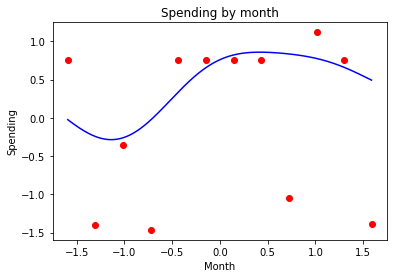

In [ ]:
X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Spending by month')
plt.xlabel('Month')
plt.ylabel('Spending')
plt.show()

It can be seen there were a few data points that were not fitted around the plane. We will try this method with the spending data in 2021. 

In [ ]:
print(regressor.predict([[-1.75]]))

[0.12644842]


 Now we will look at the spending data from 2021.

In [ ]:
df_2021 = spd_month[spd_month['year'] == 2021]
df_2021

,year,month,mth_spd
12,2021,1,6638.73
13,2021,2,149.94
14,2021,3,29.95
15,2021,4,81.91
16,2021,6,374.08
17,2021,8,8076.78
18,2021,9,637.25
19,2021,10,761.99
20,2021,11,2636.99
21,2021,12,921.21


As we can see the data from 2021 are missing some columns, therefore, we need to fill them in using the mean values. 

In [ ]:
mean_spd_2021 = df_2021['mth_spd'].mean()
mean_spd_2021 = round(mean_spd_2021, 2)
print(mean_spd_2021)

2030.88


In [ ]:
df_2021['mth_spd'] = df_2021['mth_spd'].replace([6638.73], mean_spd_2021)
df_2021['mth_spd'] = df_2021['mth_spd'].replace([8076.78], mean_spd_2021)
#df_2021['mth_spd'] = df_2021['mth_spd'].replace([2636.36], mean_spd_2021)
df_2021['mth_spd'] = df_2021['mth_spd'].replace([29.95], mean_spd_2021)
df_2021

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,year,month,mth_spd
12,2021,1,2030.88
13,2021,2,149.94
14,2021,3,2030.88
15,2021,4,81.91
16,2021,6,374.08
17,2021,8,2030.88
18,2021,9,637.25
19,2021,10,761.99
20,2021,11,2636.99
21,2021,12,921.21


<function matplotlib.pyplot.show>

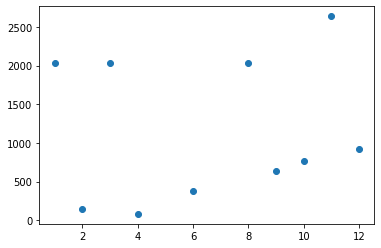

In [ ]:
plt.scatter(df_2021['month'], df_2021['mth_spd'])
plt.show

In [ ]:
X = df_2021['month'].values
y = df_2021['mth_spd'].values
sc_X = StandardScaler() 
sc_y = StandardScaler() 
X = sc_X.fit_transform(X.reshape(-1, 1)) 
y = sc_y.fit_transform(y.reshape(-1, 1))
print(X.shape)
print(y.shape)

(10, 1)
(10, 1)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.25, random_state=42)

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
print(Y_train)
print(pred_test)
print(pred_train)
print('RMSE on train data: ', mean_squared_error(Y_train, pred_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(Y_test, pred_test)**(0.5))

[[ 0.98318581]
 [-0.45860885]
 [ 0.98318581]
 [-0.27769282]
 [-0.89937721]
 [-1.23135961]
 [-0.60034648]]
[-0.25102754 -0.2665049  -0.59997456]
[-0.05895875 -0.35893914 -0.51217733 -0.17752766 -0.79921206 -0.71352799
 -0.47922022]
RMSE on train data:  0.7206145719373617
RMSE on test data:  1.5266248903608557


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


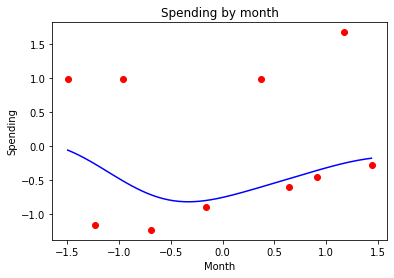

In [ ]:
X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Spending by month')
plt.xlabel('Month')
plt.ylabel('Spending')
plt.show()

In [ ]:
n_df_2020 = spd_month[spd_month['year'] == 2020]
n_df_2021 = spd_month[spd_month['year'] == 2021]
mean_spd = round(spd_month['mth_spd'].mean(), 2)
print("2020 Spending Data by Month\n {0}".format(n_df_2020))
print("\n2021 Spending Data by Month\n {0}".format(n_df_2021))
print("\n The monthly spending mean: {0}".format(mean_spd))

2020 Spending Data by Month
     year  month  mth_spd
0   2020      1  8349.20
1   2020      2    94.34
2   2020      3   780.27
3   2020      4    56.09
4   2020      5     7.09
5   2020      6     7.09
6   2020      7     7.09
7   2020      8  6668.45
8   2020      9   329.99
9   2020     10  1750.00
10  2020     11     7.09
11  2020     12   106.09

2021 Spending Data by Month
     year  month  mth_spd
12  2021      1  6638.73
13  2021      2   149.94
14  2021      3    29.95
15  2021      4    81.91
16  2021      6   374.08
17  2021      8  8076.78
18  2021      9   637.25
19  2021     10   761.99
20  2021     11  2636.99
21  2021     12   921.21

 The monthly spending mean: 1748.71


In [ ]:
n_df_2020 = n_df_2020.drop(['year'], axis = 1)
n_df_2021 = n_df_2021.drop(['year'], axis = 1)
print("\n {0}".format(n_df_2020))
print("\n {0}".format(n_df_2021))


     month  mth_spd
0       1  8349.20
1       2    94.34
2       3   780.27
3       4    56.09
4       5     7.09
5       6     7.09
6       7     7.09
7       8  6668.45
8       9   329.99
9      10  1750.00
10     11     7.09
11     12   106.09

     month  mth_spd
12      1  6638.73
13      2   149.94
14      3    29.95
15      4    81.91
16      6   374.08
17      8  8076.78
18      9   637.25
19     10   761.99
20     11  2636.99
21     12   921.21


In [ ]:
combined = pd.DataFrame({'month':[], 'mth_spd':[]})

In [ ]:
mth_5 = {'month': 5, 'mth_spd': (81.91 + 374.08) / 2}
mth_7 = {'month': 7, 'mth_spd': (81.91 + 374.08) / 2}


In [ ]:
n_df_2021 = n_df_2021.append(mth_5, ignore_index = True)


In [ ]:
n_df_2021 = n_df_2021.append(mth_7, ignore_index = True)

In [ ]:
n_df_2021 = n_df_2021.sort_values(by = ['month'])
n_df_2021

,month,mth_spd
0,1.0,6638.730
1,2.0,149.940
2,3.0,29.950
3,4.0,81.910
10,5.0,227.995
4,6.0,374.080
11,7.0,227.995
5,8.0,8076.780
6,9.0,637.250
7,10.0,761.990


In [ ]:
combined['mth_spd'] = (n_df_2020['mth_spd'].values + n_df_2021['mth_spd'].values)/2
combined['month'] = [i+1 for i in range(12)]
combined = combined.round({'mth_spd' : 2})
combined

,month,mth_spd
0,1,7493.96
1,2,122.14
2,3,405.11
3,4,69.00
4,5,117.54
5,6,190.58
6,7,117.54
7,8,7372.62
8,9,483.62
9,10,1255.99


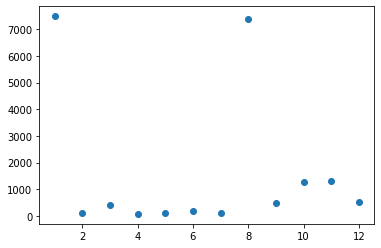

In [ ]:
plt.scatter(combined['month'], combined['mth_spd'])
plt.show()

In [ ]:
combined['mth_spd'] = combined['mth_spd'].replace([7493.96], mean_spd)
combined['mth_spd'] = combined['mth_spd'].replace([7372.62], mean_spd)

In [ ]:
combined

,month,mth_spd
0,1,1748.71
1,2,122.14
2,3,405.11
3,4,69.00
4,5,117.54
5,6,190.58
6,7,117.54
7,8,1748.71
8,9,483.62
9,10,1255.99


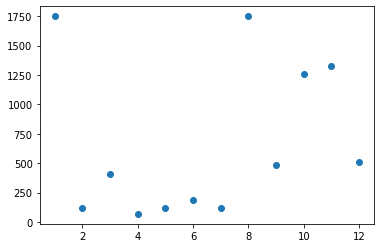

In [ ]:
plt.scatter(combined['month'], combined['mth_spd'])
plt.show()

In [ ]:
X = combined['month'].values
y = combined['mth_spd'].values
sc_X = StandardScaler() 
sc_y = StandardScaler() 
X = sc_X.fit_transform(combined[['month']]) 
y = sc_y.fit_transform(combined[['mth_spd']])
print(X.shape)
print(y.shape)

(12, 1)
(12, 1)


In [ ]:
X

array([[-1.59325501],
       [-1.30357228],
       [-1.01388955],
       [-0.72420682],
       [-0.43452409],
       [-0.14484136],
       [ 0.14484136],
       [ 0.43452409],
       [ 0.72420682],
       [ 1.01388955],
       [ 1.30357228],
       [ 1.59325501]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.35, random_state=42)

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)
print("\n")
print("Prediction made on test set:\n {0}".format(pred_test)) #Scaled prediction
print("\n")
print("Prediction made on test set:\n {0}".format(pred_train)) #Scaled prediction
print("\n")
print('RMSE on train data: ', mean_squared_error(Y_train, pred_train)**(0.5))
print("\n")
print('RMSE on test data: ',  mean_squared_error(Y_test, pred_test)**(0.5))



Prediction made on test set:
 [ 0.29813381  0.3217665   0.04660119  0.12590905 -0.8711554 ]


Prediction made on test set:
 [-0.52932614 -0.20937015  0.1101087  -0.94023541 -0.22930164 -0.80683464
 -0.60721198]


RMSE on train data:  0.7988895317015502


RMSE on test data:  0.8798673081745854


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Reverse Scaled Prediction
pred_1 = regressor.predict(X[[1]])
p_final = sc_y.inverse_transform(pred_1.reshape(-1, 1))


In [ ]:
spd_arr = []
for i in range(12):
  pred_1 = regressor.predict(X[[i]])
  p_final = sc_y.inverse_transform(pred_1.reshape(-1, 1))
  spd_arr.append(p_final[0][0])

In [ ]:
spd_arr

[703.7991303546426,
 543.1530489817105,
 342.3505837224863,
 168.18790473490702,
 84.46638263305601,
 127.82058264884063,
 293.4698903276423,
 530.6441614402363,
 753.5722652529162,
 876.4912325492479,
 861.6594981258902,
 743.6560629077196]

In [ ]:
mth_arr = [i+1 for i in range(12)]
Predicted_Spending_2022 = pd.DataFrame({"month": mth_arr, "spending": spd_arr})

In [ ]:
print("Predicted Spending in 2022:\n {0}".format(Predicted_Spending_2022))

Predicted Spending in 2022:
     month    spending
0       1  703.799130
1       2  543.153049
2       3  342.350584
3       4  168.187905
4       5   84.466383
5       6  127.820583
6       7  293.469890
7       8  530.644161
8       9  753.572265
9      10  876.491233
10     11  861.659498
11     12  743.656063


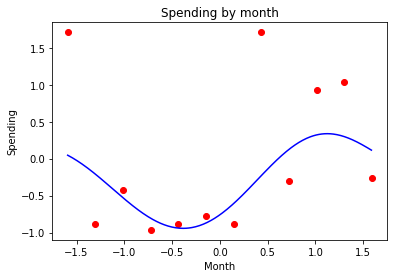

In [ ]:
X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Spending by month')
plt.xlabel('Month')
plt.ylabel('Spending')
plt.show()

# Conclusion

---

